In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
from scipy.special import gammaln
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
np.random.seed(123)

# 近似ベイズ推論：サンプリングに基づく推論手法
- パラメータの推論が解析的に行えないケースがある
  - e.g. モデルが複雑、非線形、共役関係にない分布でモデルを設計
- サンプリングに基づく推論：求めたい分布$p(\Theta | \mathcal{D})$から何らかの方法でサンプルを得ることで、その分布の統計的性質をしる

ここでは、サンプリングに基づく近似推論の一つの例として、サンプリングをベースにして積分を計算するための「単純モンテカルロ法」、そして、解析的に分布を得ることができない場合に知りたい分布からサンプルを得るための「棄却サンプリング」を実装する。

## 単純モンテカルロ法(simple Monte Carlo method)
分布$p(\mathbf{z})$に関して、ある関数$f(\mathbf{z})$の期待値$\int f(\mathbf{z})p(\mathbf{z})d\mathbf{z}$を考える。

分布$p(\mathbf{z})$からのT個のサンプルに基づいて近似する。

$$
\int f(\mathbf{z})p(\mathbf{z})d\mathbf{z} \approx \frac{1}{T}\sum^{T}_{t=1} f(\mathbf{z}^{(t)})
$$

ここで、$\mathbf{z}^{(t)}$は分布$p(\mathbf{z})$からのt番目のサンプルを表す。

### 問題設定
N個のデータを観測して、パラメータ$\theta$を持つモデル$p(\mathbf{X}, \theta)$の周辺尤度（モデルエビデンス）$p(\mathbf{X})$を単純モンテカルロ法で算出してみる。

$$
p(\mathbf{X}) = \int p(\theta) p(x_n | \theta) d\theta \approx \frac{1}{T}\sum^{T}_{t=1}\prod^{N}_{n=1} p(x_n | \theta^{(t)})
$$

ここで、シンプルな例として、データ$\mathbf{X}$が従う分布としてベルヌーイ分布を設定する。
パラメータ$\theta$はベータ分布に従うとする。

$$
\begin{eqnarray}
    p(x_n | \theta) &=& \mathrm{Bern}(x | \theta) \\
    p(\theta) &=& \mathrm{Beta}(a, b)
\end{eqnarray}
$$

ベルヌーイ分布とベータ分布は共役な関係なので、厳密な解を得ることが可能である。なお途中式についてはブログ本編を参照のこと。

$$
\begin{eqnarray}
    p(X) = \frac{\Gamma(a+b)\Gamma(m+a)\Gamma(N-m+b)}{\Gamma(a)\Gamma(b)\Gamma(a+b+N)}
\end{eqnarray}
$$

In [3]:
# テストデータ
theta = 0.1
N = 20
X = stats.bernoulli.rvs(p=theta, size=N)
print(X)

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


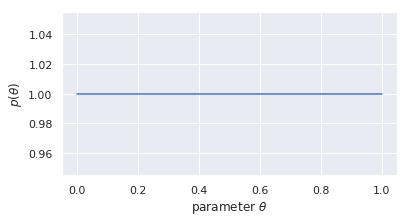

In [4]:
# パラメータの分布
a = 1.0
b = 1.0
ts = np.linspace(0, 1, 1000)
pz = stats.beta(a=a, b=b)
ys = pz.pdf(x=ts)

fig = plt.figure(figsize=(6, 3))
ax = fig.subplots(1,1)
ax.plot(ts, ys)
ret = ax.set_xlabel('parameter $\\theta$')
ret = ax.set_ylabel('$p(\\theta)$')

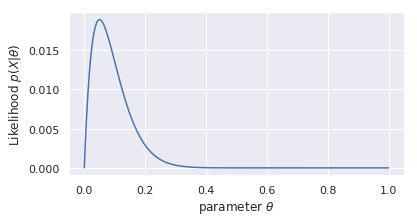

In [5]:
zs = np.linspace(0.0, 1.0, 1000)
liks = list(map(lambda z:np.prod(stats.bernoulli.pmf(k=X, p=z)), zs))

fig = plt.figure(figsize=(6, 3))
ax = fig.subplots(1,1)
ax.plot(zs, liks)
ret = ax.set_xlabel('parameter $\\theta$')
ret = ax.set_ylabel('Likelihood $p(X | \\theta)$')

### 解析解

In [6]:
# 解析解
m = sum(X)
ln_px_c = gammaln(a+b)+gammaln(m+a)+gammaln(N-m+b)-gammaln(a)-gammaln(b)-gammaln(a+b+N)
px_c = np.exp(ln_px_c)
print('Exact solution of p(X) :', px_c)

Exact solution of p(X) : 0.0023809523809523833


### 近似推論

In [7]:
# 周辺尤度p(X)の算出
# 近似解の関数の戻り値として、サンプル系列も欲しいかも
def approximate_marginal_likelihood(pz, sample_size=100000):
    """
    get approximate solution for marginal likelihood
    Args
        pz : distribution of parameter
    Returns
        px : approximate solution of marginal likelihood
    """
    zs = pz.rvs(size=sample_size)
    px = np.sum(list(map(lambda z:np.prod(stats.bernoulli.pmf(k=X, p=z)), zs)))/sample_size
    return px

a = 1.0
b = 1.0
pz = stats.beta(a=a, b=b)
px = approximate_marginal_likelihood(pz, sample_size=10000)
print('Approximate value of p(X) :', px)

Approximate value of p(X) : 0.002339328667535013


CPU times: user 1min 7s, sys: 459 ms, total: 1min 7s
Wall time: 1min 8s


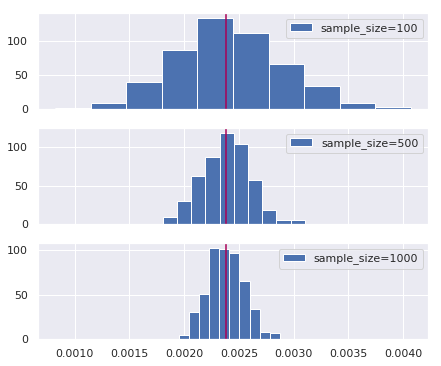

In [8]:
%%time
sss = [100, 500, 1000]

fig = plt.figure(figsize=(7, 2*len(sss)))
ax = fig.subplots(len(sss),1, sharex=True)

cnt = 0
pxs_lst = []
for ss in sss:
    pxs = [approximate_marginal_likelihood(pz, sample_size=ss) for i in np.arange(1, 500)]
    pxs_lst.append(pxs)
    ax[cnt].hist(pxs, label='sample_size=%s'%ss)
    ax[cnt].axvline(px_c, color='#AA0055')
    ax[cnt].legend()
    cnt+=1


ということで、こういう簡単な近似でも解析解に近い値が得られることがわかった。
また、サンプルサイズを増やせば、近似精度（近似値のばらつき）が小さくなることもわかった。

しかし、計算時間が結構かかる。

## 棄却サンプリング
性質の不明な分布$p(\mathbf{x})$からサンプル$z^{(l)}$を得るためのシンプルなアルゴリズム。


### アルゴリズム
- サンプルを得たい目標分布 : $p(z)$
- 目標分布に比例する正規化されていない分布 : $p(z) = \frac{1}{Z_p}\tilde{p}(z)$
- 以下のアルゴリズムでサンプルを生成
  1. 仮の分布として提案分布$q(z)$を作成する
  2. 定数kを任意のzに対して$kq(z) \ge \tilde{p}(z)$が成立するように定める
  3. サンプル$z^{(t)}$を提案分布$q(z)$から取得する
  4. サンプル$\tilde{u}$を区間$[0,kq(z^{(t)})]$の一様分布$\mathrm{Uni}(u|0,kq(z^{(t)}))$から取得する
  5. $\tilde{u} > \tilde{p}(z^{(t)})$ならばサンプル$z^{(t)}$を棄却する。$\tilde{u} \le \tilde{p}(z^{(t)})$ならばサンプル$z^{(t)}$を受容する

ここで、正規化されていない分布$\tilde{p}(x)$とは、事後分布においては尤度関数と事前分布の積を意味する。

### 問題設定
事後分布$p(\Theta | \mathcal{D})$を棄却サンプリングで近似推論する例を考える。

先のモンテカルロ積分の問題と同様に、データ$\mathbf{X}$が従う分布としてベルヌーイ分布を設定する。
パラメータ$\theta$はベータ分布に従うとする。
N個のデータ$X=\{x_1, x=2, \cdots, x_N\}$を観測した場合のパラメータ$\theta$の事後分布$p(\theta | X)$推論する。


### モデル
真の分布

$$
p(\theta |X) = \frac{p(X|\theta)p(\theta)}{p(X)} \propto p(X|\theta)p(\theta)
$$

周辺尤度$p(X)$はモンテカルロ積分のところで出てきたように、積分をする必要があるので計算が大変。
しかし、これは$\theta$が関係しない項なので、分子の要素が求めたい事後分布$p(\theta | X)$に比例する。

$$
\tilde{p}(X) = p(X|\theta)p(\theta)
$$

次に、提案分布$q(x)$と定数kを設計する。

- $q(x)$には、一様分布を利用してみる
- $p(x_i|\theta)$はベルヌーイ分布を設定するため、最大値は1。$p(\theta)$は$\mathrm{Beta}(a=1, b=1)$を設定するため、これも最大値は1。よって、$kq(z) \ge \tilde{p}(z)$が成立するために、k=1とすれば十分である。

### 実装

In [9]:
# テストデータ
theta = 0.1
N = 100
X = stats.bernoulli.rvs(p=theta, size=N)
print(X)

[0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]


#### 解析解

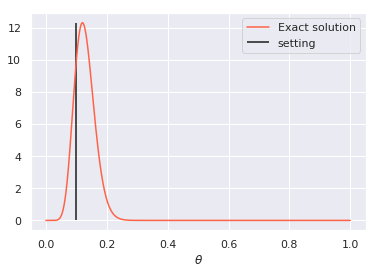

In [10]:
# 解析解
a_hat = a + np.sum(X)
b_hat = b + N - np.sum(X)
analysis_dist = stats.beta(a=a_hat, b=b_hat)
ts = np.linspace(0, 1, 1000)
tt = analysis_dist.pdf(ts)

bins = np.arange(0, 1.0, 0.01)

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
ax.plot(ts, tt, color='#ff6347', label='Exact solution')
ax.vlines(theta, 0, max(tt), label='setting')
ax.set_xlabel('$\\theta$')
plt.legend()

二つの方法がある
- ベルヌーイ分布でそのまま尤度を計算すると、席の部分で値が小さくなりすぎる
  - 定数をかけても比例することには変わりないので、二項係数をかける
- ベルヌーイ分布の尤度関数は二項分布になるので、二項分布を尤度関数に用いる

結局、どっちも同じ。

#### ベルヌーイ分布で尤度を計算

In [11]:
%%time
proposal_dist = stats.uniform(loc=0, scale=1)
k = 1.0
a=1.0
b=1.0
p_tilde_lik = stats.bernoulli
p_tilde_prior = stats.beta(a=a, b=b)

n_sample = 500
zs_1 = []
cnt=0

pbar = tqdm(total=n_sample)
while len(zs_1) < n_sample:
    z = proposal_dist.rvs()
    q_z = proposal_dist.pdf(z)
    u = stats.uniform.rvs(loc=0, scale=k*q_z)
    lik = scipy.special.comb(N, sum(X)) * np.prod(p_tilde_lik.pmf(k=X, p=z))
    prior = p_tilde_prior.pdf(z)
    p_tilde = lik * prior
    if u <= p_tilde:
        zs_1.append(z)
        pbar.update(1)
    cnt+=1
    if cnt>n_sample*100:
        print('over iter')
        break
pbar.close()

100%|█████████▉| 499/500 [00:23<00:00, 21.02it/s]

over iter
CPU times: user 23.1 s, sys: 1.28 s, total: 24.4 s
Wall time: 23.7 s


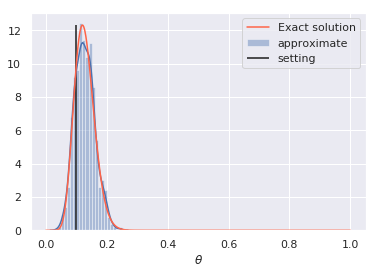

In [12]:
bins = np.arange(0, 1.0, 0.01)

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

sns.distplot(zs_1, bins=bins, ax=ax, label='approximate')
ax.plot(ts, tt, color='#ff6347', label='Exact solution')
ax.vlines(theta, 0, max(tt), label='setting')
ax.set_xlabel('$\\theta$')
plt.legend()


#### 二項分布で尤度を計算

In [13]:
%%time
proposal_dist = stats.uniform(loc=0, scale=1)
k = 1.0
a=1.0
b=1.0
p_tilde_lik = stats.binom
p_tilde_prior = stats.beta(a=a, b=b)

cnt=0
n_sample = 500
zs_2 = []
i = 0
pbar = tqdm(total=n_sample)
while i < n_sample:
    z = proposal_dist.rvs()
    q_z = proposal_dist.pdf(z)
    u = stats.uniform.rvs(loc=0, scale=k*q_z)
    lik = p_tilde_lik.pmf(np.sum(X), N, p=z)
    prior = p_tilde_prior.pdf(z)
    if u <= lik*prior:
        zs_2.append(z)
        i += 1
        pbar.update(1)
    cnt+=1
    if cnt>n_sample*100:
        print('over iter')
        break
pbar.close()

100%|██████████| 500/500 [00:23<00:00, 21.28it/s]

CPU times: user 22.8 s, sys: 3.52 s, total: 26.3 s
Wall time: 23.5 s


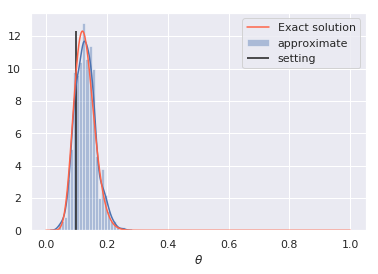

In [14]:
bins = np.arange(0, 1.0, 0.01)

fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)

sns.distplot(zs_2, bins=bins, ax=ax, label='approximate')
ax.plot(ts, tt, color='#ff6347', label='Exact solution')
ax.vlines(theta, 0, max(tt), label='setting')
ax.set_xlabel('$\\theta$')
plt.legend()
